# Chapter 8

Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [2]:
import numpy as np

import thinkstats2
import thinkplot

D:\Anaconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## The estimation game


Root mean squared error is one of several ways to summarize the average error of an estimation process.

In [3]:
def RMSE(estimates, actual):
    """Computes the root mean squared error of a sequence of estimates.

    estimate: sequence of numbers
    actual: actual value

    returns: float RMSE
    """
    e2 = [(estimate-actual)**2 for estimate in estimates]
    mse = np.mean(e2)
    return np.sqrt(mse)

The following function simulates experiments where we try to estimate the mean of a population based on a sample with size `n=7`.  We run `iters=1000` experiments and collect the mean and median of each sample.

In [8]:
import random

def Estimate1(n=7, iters=1000):
    """Evaluates RMSE of sample mean and median as estimators.

    n: sample size
    iters: number of iterations
    """
    mu = 0
    sigma = 1

    means = []
    medians = []
    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for _ in range(n)]
        xbar = np.mean(xs)
        median = np.median(xs)
        means.append(xbar)
        medians.append(median)

    print('Experiment 1')
    print('rmse xbar', RMSE(means, mu))
    print('rmse median', RMSE(medians, mu))
    
Estimate1()

Experiment 1
rmse xbar 0.3792716144614154
rmse median 0.4447402342741178


Using $\bar{x}$ to estimate the mean works a little better than using the median; in the long run, it minimizes RMSE.  But using the median is more robust in the presence of outliers or large errors.


## Estimating variance

The obvious way to estimate the variance of a population is to compute the variance of the sample, $S^2$, but that turns out to be a biased estimator; that is, in the long run, the average error doesn't converge to 0.

The following function computes the mean error for a collection of estimates.

In [9]:
def MeanError(estimates, actual):
    """Computes the mean error of a sequence of estimates.

    estimate: sequence of numbers
    actual: actual value

    returns: float mean error
    """
    errors = [estimate-actual for estimate in estimates]
    return np.mean(errors)

The following function simulates experiments where we try to estimate the variance of a population based on a sample with size `n=7`.  We run `iters=1000` experiments and two estimates for each sample, $S^2$ and $S_{n-1}^2$.

In [13]:
def Estimate2(n=7, iters=1000):
    mu = 0
    sigma = 1

    estimates1 = []
    estimates2 = []
    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        biased = np.var(xs)
        unbiased = np.var(xs, ddof=1)
        estimates1.append(biased)
        estimates2.append(unbiased)

    print('mean error biased', MeanError(estimates1, sigma**2))
    print('mean error unbiased', MeanError(estimates2, sigma**2))
    
Estimate2()

mean error biased -0.15541328470821303
mean error unbiased -0.014648832159581893


The mean error for $S^2$ is non-zero, which suggests that it is biased.  The mean error for $S_{n-1}^2$ is close to zero, and gets even smaller if we increase `iters`.

## The sampling distribution

The following function simulates experiments where we estimate the mean of a population using $\bar{x}$, and returns a list of estimates, one from each experiment.

In [14]:
def SimulateSample(mu=90, sigma=7.5, n=9, iters=1000):
    xbars = []
    for j in range(iters):
        xs = np.random.normal(mu, sigma, n)
        xbar = np.mean(xs)
        xbars.append(xbar)
    return xbars

xbars = SimulateSample()

Here's the "sampling distribution of the mean" which shows how much we should expect $\bar{x}$ to vary from one experiment to the next.

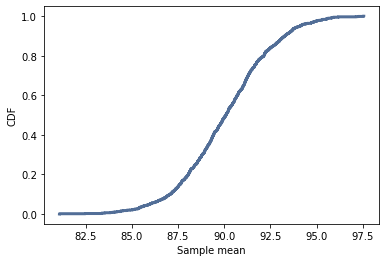

In [15]:
cdf = thinkstats2.Cdf(xbars)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Sample mean',
                 ylabel='CDF')

The mean of the sample means is close to the actual value of $\mu$.

In [16]:
np.mean(xbars)

90.08343009475738

An interval that contains 90% of the values in the sampling disrtribution is called a 90% confidence interval.

In [17]:
ci = cdf.Percentile(5), cdf.Percentile(95)
ci

(85.98820072054178, 94.08779872999126)

And the RMSE of the sample means is called the standard error.

In [13]:
stderr = RMSE(xbars, 90)
stderr

Confidence intervals and standard errors quantify the variability in the estimate due to random sampling.

## Estimating rates

The following function simulates experiments where we try to estimate the mean of an exponential distribution using the mean and median of a sample. 

In [18]:
def Estimate3(n=7, iters=1000):
    lam = 2

    means = []
    medians = []
    for _ in range(iters):
        xs = np.random.exponential(1.0/lam, n)
        L = 1 / np.mean(xs)
        Lm = np.log(2) / thinkstats2.Median(xs)
        means.append(L)
        medians.append(Lm)

    print('rmse L', RMSE(means, lam))
    print('rmse Lm', RMSE(medians, lam))
    print('mean error L', MeanError(means, lam))
    print('mean error Lm', MeanError(medians, lam))
    
Estimate3()

rmse L 1.072144826380826
rmse Lm 1.8801128493477948
mean error L 0.3161808525600851
mean error Lm 0.42439173359715576


The RMSE is smaller for the sample mean than for the sample median.

But neither estimator is unbiased.

## Exercises

**Exercise:** Suppose you draw a sample with size n=10 from an exponential distribution with λ=2. Simulate this experiment 1000 times and plot the sampling distribution of the estimate L. Compute the standard error of the estimate and the 90% confidence interval.

Repeat the experiment with a few different values of `n` and make a plot of standard error versus `n`.



In [23]:
?np.random.exponential

In [29]:
def SimulateExpSample(lam=2, n=10, iters=1000):
    Ls = []
    for j in range(iters):
        xs = np.random.exponential(lam, n)
        L = np.mean(xs)
        Ls.append(L)
    return Ls

Ls = SimulateExpSample()

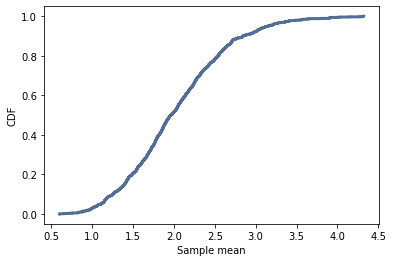

In [30]:
cdf = thinkstats2.Cdf(Ls)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Sample mean',
                 ylabel='CDF')

In [31]:
# Mean of the sample means
np.mean(Ls)

2.0303825147203836

In [32]:
# 90% confidence interval
ci = cdf.Percentile(5), cdf.Percentile(95)
ci

(1.1057990900457828, 3.144397409745693)

In [35]:
# Standard Error
stderr = RMSE(Ls, 2)
stderr

0.6267040845820196

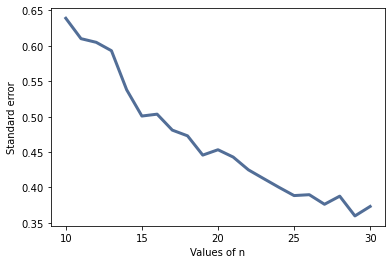

In [53]:
ns = np.arange(10, 31, 1)
lam = 2
stderrs = []

for value in ns:
    Ls = SimulateExpSample(lam=lam, n=value, iters = 1000)
    stderrs.append(RMSE(Ls, lam))

thinkplot.Plot(ns, stderrs)
thinkplot.Config(xlabel = 'Values of n',
                 ylabel = 'Standard error',
                 xticks = list(range(10, 31, 5))
                )
    

**Exercise:** In games like hockey and soccer, the time between goals is roughly exponential. So you could estimate a team’s goal-scoring rate by observing the number of goals they score in a game. This estimation process is a little different from sampling the time between goals, so let’s see how it works.

Write a function that takes a goal-scoring rate, `lam`, in goals per game, and simulates a game by generating the time between goals until the total time exceeds 1 game, then returns the number of goals scored.

Write another function that simulates many games, stores the estimates of `lam`, then computes their mean error and RMSE.

Is this way of making an estimate biased?

In [54]:
def SimulateGame(lam):
    """Simulates a game and returns the estimated goal-scoring rate.

    lam: actual goal scoring rate in goals per game
    """
    goals = 0
    t = 0
    while True:
        time_between_goals = random.expovariate(lam)
        t += time_between_goals
        if t > 1:
            break
        goals += 1

    # estimated goal-scoring rate is the actual number of goals scored
    L = goals
    return L

In [72]:
def GamesSimulation(n, lam):
    L_estimates = []
    for game in range(n):
        L_estimates.append(SimulateGame(lam))
    mean_error = MeanError(L_estimates, lam)
    rmse = RMSE(L_estimates, lam)
    return mean_error, rmse

In [77]:
GamesSimulation(100000, 100)

(0.01327, 9.991873197754263)

**Exercise:**  In this chapter we used $\bar{x}$ and median to estimate µ, and found that $\bar{x}$ yields lower MSE. Also, we used $S^2$ and $S_{n-1}^2$ to estimate σ, and found that $S^2$ is biased and $S_{n-1}^2$ unbiased.
Run similar experiments to see if $\bar{x}$ and median are biased estimates of µ. Also check whether $S^2$ or $S_{n-1}^2$ yields a lower MSE.

In [106]:
%%time

mu = 20
sigma = 2
n = 30 # Sample size
experiments = 100000
xbar_ests = []
sample_median_ests = []
biased = []
unbiased = []

for i in range(experiments):
    xs = np.random.normal(mu, sigma, n)
    xbar = np.mean(xs)
    sample_median = np.median(xs)
    xbar_ests.append(xbar)
    sample_median_ests.append(sample_median)
    biased.append(np.var(xs))
    unbiased.append(np.var(xs, ddof=1))
    
(MeanError(xbar_ests, mu), MeanError(sample_median_ests, mu))
# Conclusion: Both xbar and median are unbiased estimates of u for a normal distribution
(MeanError(biased, sigma**2), MeanError(unbiased, sigma**2))

CPU times: total: 12.5 s
Wall time: 12.5 s


(-0.13679735617844035, -0.003583471908731424)

In [16]:
(MeanError(xbar_ests, mu), MeanError(sample_median_ests, mu))
# Conclusion: Both xbar and median are unbiased estimates of u for a normal distribution

In [107]:
(RMSE(biased, sigma**2), RMSE(unbiased, sigma**2))
# Conclusion: They have similar MSEs

(1.0184640154220719, 1.0440424329738767)